# What do I want?

1) dispersion and temperature for all sats including theoretical limits

2) present day vmax_function (vpeak function?)

3) radial distributions above 4.5

4) figure of test models

5) effect of models on radial distribution

6) Vmax distributions of filled halos (normalized/unnormalized?)

In [1]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [9]:
import numpy as np
import pandas as pd
import h5py, itertools, scipy.stats
import matplotlib.pyplot as plt
import sys, os, re
from scipy.special import erf
from scipy.optimize import curve_fit
from andrew_tools.simple_tools import high_low_limit
import Claires_modules
from random import gauss

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

In [7]:
def make_rand_vector(dims):
    import numpy as np
    vec = [gauss(0, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return np.array([x/mag for x in vec])

def cart2sph(x,y,z):
    import numpy as np
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def Only_DES_cartesian(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, MW, pnts=1,M_t=8.0):
    import numpy as np
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    
    DES_cone_len = 1.0 #Satellite[lstn][5]/1000.

    DES_cone_size = 0.69
    SDSS_coneS_size = 0.69  #t2
    SDSS_coneB_size = 0.9626   #t|
    #test values
    #DES_cone_size = np.pi/4.0
    #SDSS_coneS_size = np.pi/4.0  #t2
    #SDSS_coneB_size = np.pi/4.0   #t3
    
    #Define everything relative to DES vector
    des_direction = make_rand_vector(3)
    
    angles = cart2sph(*des_direction)
    the_t = angles[2]
    phi_t = angles[1]

    #I believe this next bit fixes SDSS relative to the DES fields
    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72
    
    #test vectors
    #des_direction = [1.0,0.0,0.0]
    #sdss_direction_one = [0.0,1.0,0.0]
    #sdss_direction_two = [0.0,0.0,1.0]
    sdss_direction_one = [np.cos(the_t2)*np.sin(phi_t2),np.sin(the_t2)*np.sin(phi_t2),np.cos(phi_t2)]
    sdss_direction_two = [np.cos(the_t3)*np.sin(phi_t3),np.sin(the_t3)*np.sin(phi_t3),np.cos(phi_t3)]
    
    h = 0.6751
    
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    coord_dist = z0_cens - z0_cens[MW]
    coord_norms = np.apply_along_axis(linalg.norm,1,coord_dist)
    
    coord_vectors = coord_dist / coord_norms.reshape((len(coord_norms),-1))
    
    #distances_from_center = np.linalg.norm(coord_dist,axis=1)[np.newaxis]

    dis = np.arccos(np.dot(coord_vectors,des_direction))
    dis2 = np.arccos(np.dot(coord_vectors,sdss_direction_one))
    dis3 = np.arccos(np.dot(coord_vectors,sdss_direction_two))    
    
    in_DES = (dis <= DES_cone_size)
    in_SDSS_one = (dis2 <= SDSS_coneS_size)
    in_SDSS_two = (dis3 <= SDSS_coneB_size)
    return in_DES, in_SDSS_one, in_SDSS_two, des_direction, sdss_direction_one, sdss_direction_two

[9.2, 3.4, 2.2, 2.7, 11.7, 4.9, 3.3, 6.9, 6.6, 3.4, 5.6, 6.7, 7.5, 3.7, 9.2, 7.9, 7.6, 4.0, 7.4, 2.3, 3.3, 2.7, 3.6, 4.6, 4.6, 7.6, 10.5, 4.6, 9.5, 8.4, 5.1, 9.1, 9.6, 5.4, 5.4, 8.6, 2.9, 5.4, 1.2]
[6628.553528075808, 905.3175659801078, 379.0429947529172, 570.9139321794972, 10720.494948703888, 1880.335186780484, 852.8467381940635, 3728.5613595426416, 3411.386952776254, 905.3175659801078, 2455.9479990602235, 3515.54546166497, 4405.200093977601, 1072.1278095387268, 6628.553528075808, 4887.61845093586, 4523.4552431670445, 1253.0346933980734, 4288.511238154907, 414.284595504738, 852.8467381940635, 570.9139321794972, 1014.9581016524395, 1657.138382018952, 1657.138382018952, 4523.4552431670445, 8634.192184196098, 1657.138382018952, 7067.898817448508, 5525.882997885503, 2036.9645234552424, 6485.237685018403, 7217.4798339729, 2283.655728717989, 2283.655728717989, 5792.152870232594, 658.6263607173622, 2283.655728717989, 112.77312240582657]


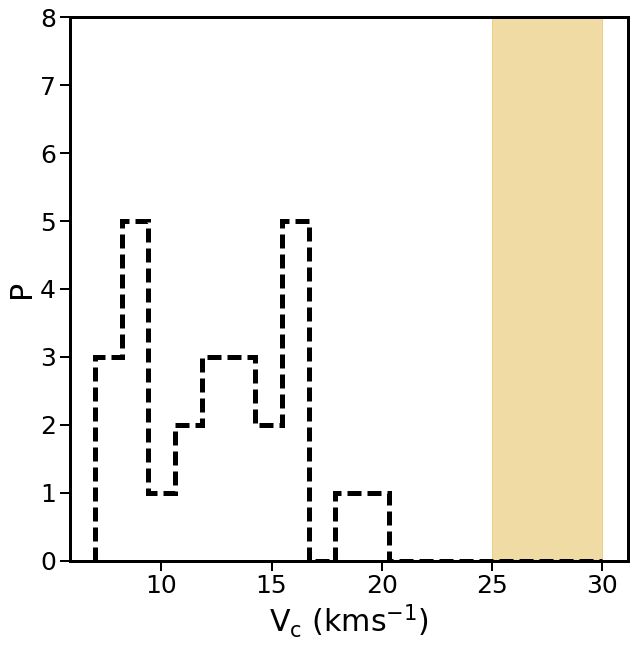

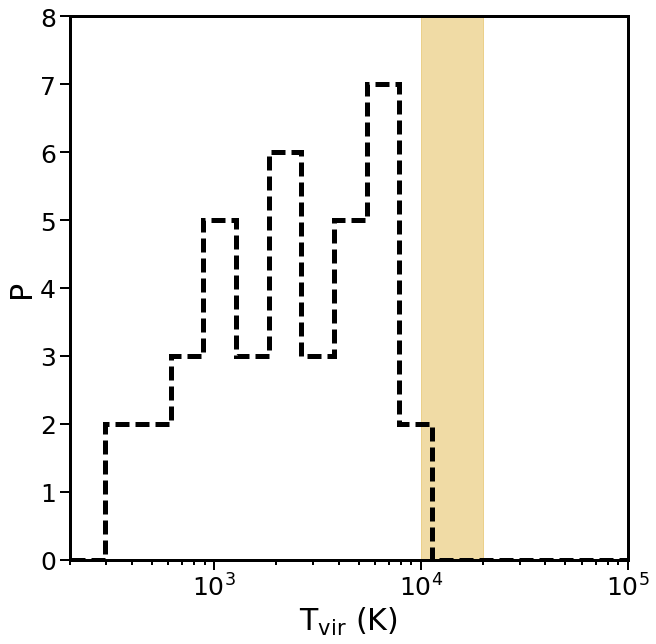

In [94]:
Vdisp = [9.1,9.5,11.4,9.,7.8,9.4,2.4,10.5,7.6,4.6,4.6,3.7,3.3,3.7,7.5,7.9,3.9,3.4,7.6,6.7,
         4.3,6.9,2.9,4.9,3.22,8.6,0.1,2.7,2.9,14.]

Vdisp = [6.6,9.1,11.7,9.2,6.6,9.5,9.2,7.9,11.4,9.,7.8,9.4,2.4,10.5,7.6,4.6,4.6,3.7,
         3.3,3.7,7.5,7.9,3.9,3.4,7.6,6.7,4.3,6.9,2.9,4.9,3.22,8.6,0.1,2.7,2.9,14.] #"complete"

Jsimon_data = np.loadtxt('/Users/andrewgraus/Downloads/mwdwarfs_sigma.dat',dtype=object)
Vdisp_js = [float(xx) for xx in Jsimon_data[:,1]]
Vdisp = [xx for xx in Vdisp_js if xx!=-9.9]

Vc = [np.sqrt(3.0*xx**2.0) for xx in Vdisp]
T_vir = [1.0e4*(xx/11.3)**2.0 for xx in Vdisp]

print Vdisp
print T_vir

v_bins = np.linspace(7.0,30.0,20)
T_bins = np.logspace(2.0,5.0,20)

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

weights = np.ones_like(Vc)*(1.0/float(len(Vdisp)))

#plt.hist(Vc,bins=v_bins,weights=weights,color='k',linestyle='--',histtype='step',linewidth=5)
plt.hist(Vc,bins=v_bins,color='k',linestyle='--',histtype='step',linewidth=5)
plt.fill_betweenx([0.0,100.0],25.0,30.0,color='GoldenRod',alpha=0.4)

plt.xlabel('$V_{c}$ ($km s^{-1}$)',fontsize=30)
plt.ylabel('P',fontsize=30)
plt.ylim([0.0,8.0])
#plt.ylim([0.0,0.2])
plt.savefig('./plots_for_paper/V_c_real_all.png',bbox_inches='tight')
plt.show()

fig1 = plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

#plt.hist(T_vir,bins=T_bins,weights=weights,color='k',linestyle='--',histtype='step',linewidth=5)
plt.hist(T_vir,bins=T_bins,color='k',linestyle='--',histtype='step',linewidth=5)
plt.fill_betweenx([0.0,100.0],1.0e4,2.0e4,color='GoldenRod',alpha=0.4)

plt.xlabel('$T_{vir}$ (K)',fontsize=30)
plt.ylabel('P',fontsize=30)
plt.xscale('log')
plt.ylim([0.0,8.0])
#plt.ylim([0.0,0.2])
plt.xlim([200.0,1.0e5])
plt.savefig('./plots_for_paper/T_vir_real_all.png',bbox_inches='tight')
plt.show()

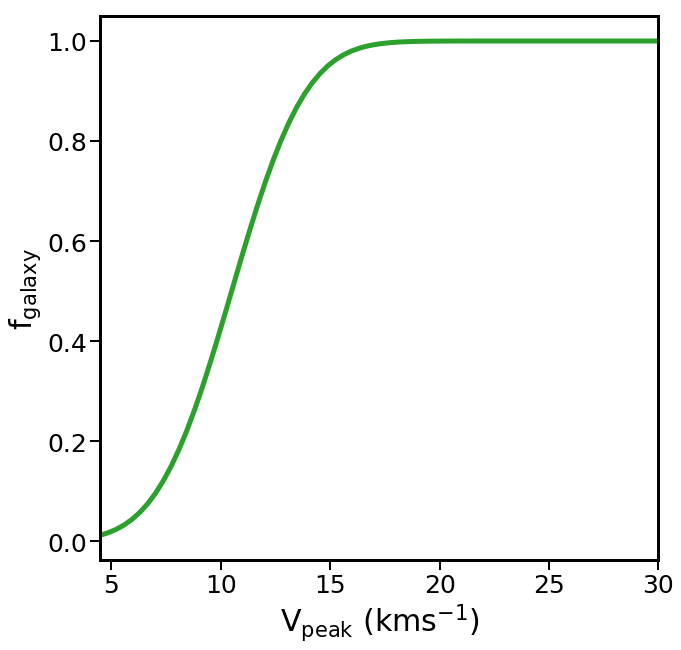

In [92]:
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

v_max_fit = np.linspace(4.5,40.0,100)

popt = [2.66718967, 18.0]
popt_wide = [2.66718967*4.0, 18.0]
popt_low = [2.66718967, 20.98533531/2.0]
popt_bad = [14.5,0.0]

orig_fit = normal_cdf(v_max_fit,*popt)
wide_fit = normal_cdf(v_max_fit,*popt_wide)
low_fit = normal_cdf(v_max_fit,*popt_low)
bad_fit = normal_cdf(v_max_fit,*popt_bad)

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([4.5,30.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$V_{peak}$ $(km s^{-1})$',fontsize=30)
plt.ylabel('$f_{galaxy}$',fontsize=30)

#plt.plot(v_max_fit,orig_fit,color='C0',linewidth=5)
#plt.plot(v_max_fit,wide_fit,color='C1',linewidth=5)
plt.plot(v_max_fit,low_fit,color='C2',linewidth=5)
#plt.plot(v_max_fit,bad_fit,color='C3')

plt.legend(loc=1, prop={'size': 20})
#plt.xscale('log')
plt.savefig('./plots_for_paper/models_low.png',bbox_inches='tight')
plt.show()

In [152]:
#I want to plot everything within 50 kpc of each disk sim
#and the vmax spectrum of these things

v_bins = np.linspace(0.0,100.0,100)
v_bins_plot = [(v_bins[ii+1]+v_bins[ii])/2.0 for ii in range(len(v_bins)-1)]

r_bins = np.linspace(0.0,100.0,100)
r_bins_plot = [(r_bins[ii+1]+r_bins[ii])/2.0 for ii in range(len(r_bins)-1)]

radius_hist, vpeak_hist, vmax_hist = [],[],[]
radius_hist_dark, vpeak_hist_dark, vmax_hist_dark = [],[],[]

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]
    
    distances = np.sqrt((Data_X_norm)**2.0+(Data_Y_norm)**2.0+(Data_Z_norm)**2.0)
    
    hist_r, bins_r = np.histogram(distances[(distances>0.0)],r_bins)
    hist_r_c = np.cumsum(hist_r)
    radius_hist.append(hist_r_c)
    
    hist_vmax, bins_vmax = np.histogram(Data_Vmax_cut[(distances<100.0)&(distances>0.0)],bins=v_bins)
    hist_vmax_c = np.cumsum(hist_vmax[::-1])[::-1]
    vmax_hist.append(hist_vmax_c)
    
    hist_vpeak, bins_vpeak = np.histogram(Data_Vpeak_cut[(distances<100.0)&(distances>0.0)],bins=v_bins)
    hist_vpeak_c = np.cumsum(hist_vpeak[::-1])[::-1]
    vpeak_hist.append(hist_vpeak_c)
    
for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_dmo_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_dmo_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]
    
    distances = np.sqrt((Data_X_norm)**2.0+(Data_Y_norm)**2.0+(Data_Z_norm)**2.0)
    
    hist_r, bins_r = np.histogram(distances[(distances>0.0)],r_bins)
    hist_r_c = np.cumsum(hist_r)
    radius_hist_dark.append(hist_r_c)
    
    hist_vmax, bins_vmax = np.histogram(Data_Vmax_cut[(distances<100.0)&(distances>0.0)],bins=v_bins)
    hist_vmax_c = np.cumsum(hist_vmax[::-1])[::-1]
    vmax_hist_dark.append(hist_vmax_c)
    
    hist_vpeak, bins_vpeak = np.histogram(Data_Vpeak_cut[(distances<100.0)&(distances>0.0)],bins=v_bins)
    hist_vpeak_c = np.cumsum(hist_vpeak[::-1])[::-1]
    vpeak_hist_dark.append(hist_vpeak_c)
    
radius_hist = np.array(radius_hist)
hist_rad_mean = np.mean(radius_hist,axis=0)
hist_rad_med = np.median(radius_hist,axis=0)
hist_rad_min = np.min(radius_hist,axis=0)
hist_rad_max = np.max(radius_hist,axis=0)

vmax_hist = np.array(vmax_hist)
hist_vmax_mean = np.mean(vmax_hist,axis=0)
hist_vmax_med = np.median(vmax_hist,axis=0)
hist_vmax_min = np.min(vmax_hist,axis=0)
hist_vmax_max = np.max(vmax_hist,axis=0)

vpeak_hist = np.array(vpeak_hist)
hist_vpeak_mean = np.mean(vpeak_hist,axis=0)
hist_vpeak_med = np.median(vpeak_hist,axis=0)
hist_vpeak_min = np.min(vpeak_hist,axis=0)
hist_vpeak_max = np.max(vpeak_hist,axis=0)

radius_hist_dark = np.array(radius_hist_dark)
hist_rad_mean_dark = np.mean(radius_hist_dark,axis=0)
hist_rad_med_dark = np.median(radius_hist_dark,axis=0)
hist_rad_min_dark = np.min(radius_hist_dark,axis=0)
hist_rad_max_dark = np.max(radius_hist_dark,axis=0)

vmax_hist_dark = np.array(vmax_hist_dark)
hist_vmax_mean_dark = np.mean(vmax_hist_dark,axis=0)
hist_vmax_med_dark = np.median(vmax_hist_dark,axis=0)
hist_vmax_min_dark = np.min(vmax_hist_dark,axis=0)
hist_vmax_max_dark = np.max(vmax_hist_dark,axis=0)

vpeak_hist_dark = np.array(vpeak_hist_dark)
hist_vpeak_mean_dark = np.mean(vpeak_hist_dark,axis=0)
hist_vpeak_med_dark = np.median(vpeak_hist_dark,axis=0)
hist_vpeak_min_dark = np.min(vpeak_hist_dark,axis=0)
hist_vpeak_max_dark = np.max(vpeak_hist_dark,axis=0)
    

reduced_data_1107_from_mt.txt
reduced_data_1245_from_mt.txt
reduced_data_1386_from_mt.txt
reduced_data_493_from_mt.txt
reduced_data_539_from_mt.txt
reduced_data_609_from_mt.txt
reduced_data_694_from_mt.txt
reduced_data_795_from_mt.txt
reduced_data_833_from_mt.txt
reduced_data_848_from_mt.txt
reduced_data_879_from_mt.txt
reduced_data_988_from_mt.txt
reduced_data_h1107_from_dmo_mt.txt
reduced_data_h1245_from_dmo_mt.txt
reduced_data_h1386_from_dmo_mt.txt
reduced_data_h493_from_dmo_mt.txt
reduced_data_h539_from_dmo_mt.txt
reduced_data_h609_from_dmo_mt.txt
reduced_data_h694_from_dmo_mt.txt
reduced_data_h795_from_dmo_mt.txt
reduced_data_h833_from_dmo_mt.txt
reduced_data_h848_from_dmo_mt.txt
reduced_data_h879_from_dmo_mt.txt
reduced_data_h988_from_dmo_mt.txt


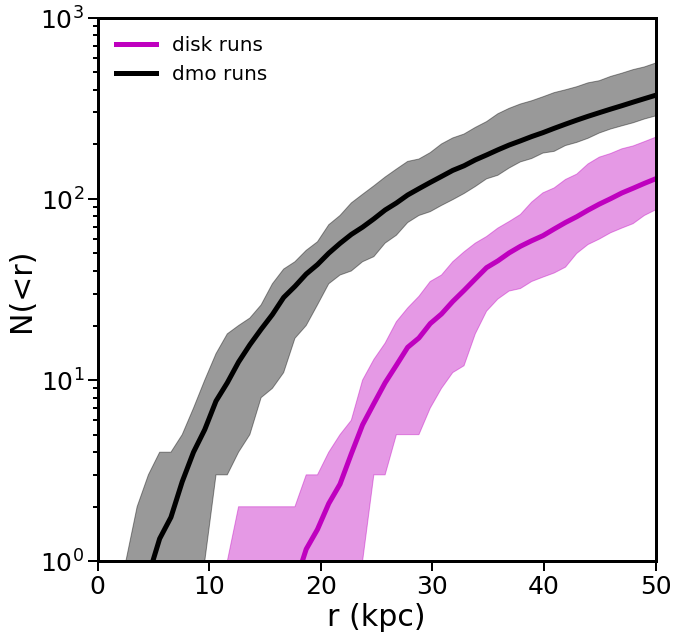

ValueError: x and y must have same first dimension, but have shapes (29,) and (99,)

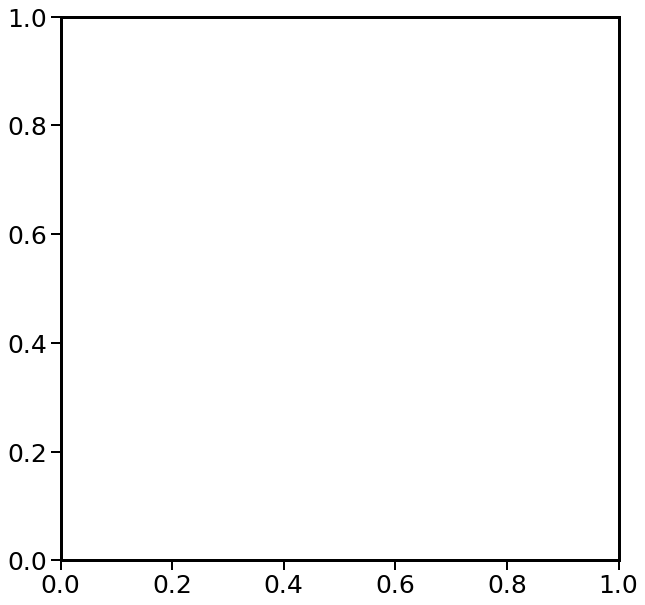

In [151]:
fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.plot(r_bins_plot,hist_rad_mean,color='m',linewidth=5,label='disk runs')
plt.fill_between(r_bins_plot,hist_rad_min,hist_rad_max,color='m',alpha=0.4)
plt.plot(r_bins_plot,hist_rad_mean_dark,color='k',linewidth=5,label='dmo runs')
plt.fill_between(r_bins_plot,hist_rad_min_dark,hist_rad_max_dark,color='k',alpha=0.4)
plt.xlim([0.0,50.0])
plt.ylim([1.0,1.0e3])
plt.xlabel('r (kpc)',fontsize=30)
plt.ylabel('N(<r)',fontsize=30)
plt.yscale('log')
plt.legend(loc=2,fontsize=20,frameon=False)
plt.savefig('./plots_for_paper/halos_in_radius.png',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.plot(v_bins_plot,hist_vmax_mean,color='m',linewidth=5,label='disk runs')
plt.fill_between(v_bins_plot,hist_vmax_min,hist_vmax_max,color='m',alpha=0.4)
plt.plot(v_bins_plot,hist_vmax_mean_dark,color='k',linewidth=5,label='dmo runs')
plt.fill_between(v_bins_plot,hist_vmax_min_dark,hist_vmax_max_dark,color='k',alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.xlim([4.5,50.0])
plt.ylim([1.0,2.0e3])
plt.legend(loc=1,fontsize=20,frameon=False)
plt.xlabel('$V_{max}$ ($km s^{-1}$)',fontsize=30)
plt.ylabel('N(>$V_{max}$)',fontsize=30)
ax.set_xticks([5, 7, 10, 20, 30])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('./plots_for_paper/halos_vmax.png',bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.plot(v_bins_plot,hist_vpeak_mean,color='m',linewidth=5,label='disk runs')
plt.plot(v_bins_plot,hist_vmax_mean,color='m',linewidth=5,label='disk runs',linestyle='--')
plt.fill_between(v_bins_plot,hist_vpeak_min,hist_vpeak_max,color='m',alpha=0.4)
plt.plot(v_bins_plot,hist_vpeak_mean_dark,color='k',linewidth=5,label='dmo runs')
plt.plot(v_bins_plot,hist_vmax_mean_dark,color='k',linewidth=5,label='dmo runs',linestyle='--')
plt.fill_between(v_bins_plot,hist_vpeak_min_dark,hist_vpeak_max_dark,color='k',alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.xlim([4.5,50.0])
plt.ylim([1.0,2.0e3])
plt.legend(loc=1,fontsize=20,frameon=False)
ax.set_xticks([5, 7, 10, 20, 30])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel('$V_{peak}$ ($km s^{-1}$)',fontsize=30)
plt.ylabel('N(>$V_{peak}$)',fontsize=30)
#plt.savefig('./plots_for_paper/halos_vpeak.png',bbox_inches='tight')
plt.show()

reduced_data_1107_from_mt.txt
reduced_data_1245_from_mt.txt
reduced_data_1386_from_mt.txt
reduced_data_493_from_mt.txt
reduced_data_539_from_mt.txt
reduced_data_609_from_mt.txt
reduced_data_694_from_mt.txt
reduced_data_795_from_mt.txt
reduced_data_833_from_mt.txt
reduced_data_848_from_mt.txt
reduced_data_879_from_mt.txt
reduced_data_988_from_mt.txt
reduced_data_h1107_from_dmo_mt.txt
reduced_data_h1245_from_dmo_mt.txt
reduced_data_h1386_from_dmo_mt.txt
reduced_data_h493_from_dmo_mt.txt
reduced_data_h539_from_dmo_mt.txt
reduced_data_h609_from_dmo_mt.txt
reduced_data_h694_from_dmo_mt.txt
reduced_data_h795_from_dmo_mt.txt
reduced_data_h833_from_dmo_mt.txt
reduced_data_h848_from_dmo_mt.txt
reduced_data_h879_from_dmo_mt.txt
reduced_data_h988_from_dmo_mt.txt


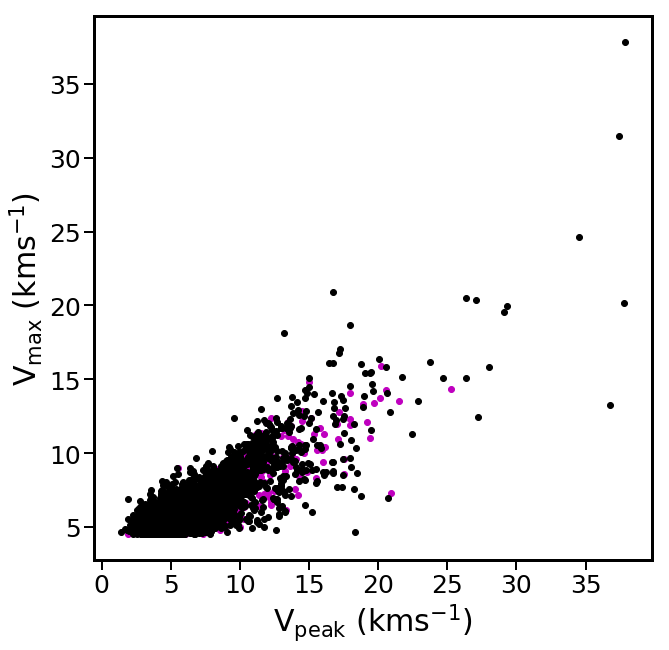

In [146]:
V_max_tot, V_peak_tot = [],[]
V_max_tot_dmo, V_peak_tot_dmo = [], []

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]
    
    distances = np.sqrt((Data_X_norm)**2.0+(Data_Y_norm)**2.0+(Data_Z_norm)**2.0)
    
    [V_max_tot.append(xx) for xx in Data_Vmax_cut[(distances<50.0)&(distances>0.0)]]
    [V_peak_tot.append(xx) for xx in Data_Vpeak_cut[(distances<50.0)&(distances>0.0)]]
    
for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_dmo_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_dmo_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Vmax_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]
    
    distances = np.sqrt((Data_X_norm)**2.0+(Data_Y_norm)**2.0+(Data_Z_norm)**2.0)
    
    [V_max_tot_dmo.append(xx) for xx in Data_Vmax_cut[(distances<50.0)&(distances>0.0)]]
    [V_peak_tot_dmo.append(xx) for xx in Data_Vpeak_cut[(distances<50.0)&(distances>0.0)]]
     
fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
     
plt.scatter(V_peak_tot,V_max_tot,color='m')
plt.scatter(V_peak_tot_dmo,V_max_tot_dmo,color='k')
     
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([4.5,50.0])
#plt.ylim([1.0,2.0e3])
plt.legend(loc=1,fontsize=20,frameon=False)
plt.xlabel('$V_{peak}$ ($km s^{-1}$)',fontsize=30)
plt.ylabel('$V_{max}$ ($km s^{-1}$)',fontsize=30)
#plt.savefig('./plots_for_paper/halos_vpeak.png',bbox_inches='tight')
plt.show()

882 1503 43
2173 4382


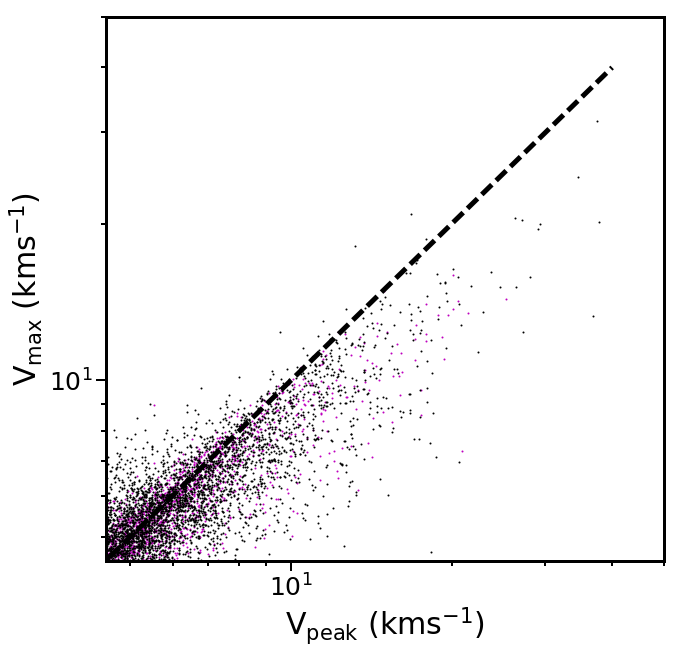

In [154]:
fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)


print np.sum((np.array(V_peak_tot)>np.array(V_max_tot))), len(V_peak_tot),np.sum((np.array(V_peak_tot)==np.array(V_max_tot)))
print np.sum((np.array(V_peak_tot_dmo)>np.array(V_max_tot_dmo))), len(V_peak_tot_dmo)


plt.scatter(V_peak_tot,V_max_tot,color='m',s=1)
plt.scatter(V_peak_tot_dmo,V_max_tot_dmo,color='k',s=1)
plt.plot([0.0,40.0],[0.0,40.0],color='k',linestyle='--',linewidth=5)
     
plt.yscale('log')
plt.xscale('log')
plt.xlim([4.5,50.0])
plt.ylim([4.5,50.0])
plt.legend(loc=1,fontsize=20,frameon=False)
plt.xlabel('$V_{peak}$ ($km s^{-1}$)',fontsize=30)
plt.ylabel('$V_{max}$ ($km s^{-1}$)',fontsize=30)
plt.savefig('./plots_for_paper/vmax_vpeak.png',bbox_inches='tight')
plt.show()

In [68]:
h = 0.6751

numbins = 1000

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]
hist_total_fid, hist_total_wide, hist_total_low = [],[],[]

r_bins = np.linspace(0.0,100.0,numbins)
r_bins_plot = np.array([(r_bins[ii]+r_bins[ii+1])/2.0 for ii in range(len(r_bins)-1)])

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]

    print Data_Mass_cut[host_index]/1.0e12

    Andr = 0
    MW = host_index

    for ii in range(100):
        in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, MW)

        distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

        in_all = in_des | in_sdss_b | in_sdss_s

        hist_tot, bins_tot = np.histogram(distances[(distances>0.0)],r_bins)
        hist_tot_c = np.cumsum(hist_tot)
        hist_total_all.append(hist_tot_c)
        #hist_total_all = np.vstack((hist_total_all,hist_tot_c))

        hist_des, bins_des = np.histogram(distances[np.newaxis].T[in_des&(distances>0.0)],r_bins)
        hist_des_c = np.cumsum(hist_des)
        hist_total_des.append(hist_des_c)
        #hist_total_des = np.vstack((hist_total_des,hist_des_c))

        hist_both, bins_both = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)],r_bins)
        hist_both_c = np.cumsum(hist_both)
        hist_total_both.append(hist_both_c)
        #hist_total_both = np.vstack((hist_total_both,hist_both_c))
        
        hist_fid, bins_fid = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip],r_bins)
        hist_fid_c = np.cumsum(hist_fid)
        hist_total_fid.append(hist_fid_c)
        
        hist_wide, bins_wide = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip_wide],r_bins)
        hist_wide_c = np.cumsum(hist_wide)
        hist_total_wide.append(hist_wide_c)
        
        hist_low, bins_low = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip_low],r_bins)
        hist_low_c = np.cumsum(hist_low)
        hist_total_low.append(hist_low_c)

reduced_data_1107_from_mt.txt
1.7859999999999998e-10


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in less_equal


reduced_data_1245_from_mt.txt
1.7293000000000002e-10
reduced_data_1386_from_mt.txt
1.6350999999999999e-10
reduced_data_493_from_mt.txt
2.0222999999999998e-10
reduced_data_539_from_mt.txt
2.0571e-10
reduced_data_609_from_mt.txt
1.9558e-10
reduced_data_694_from_mt.txt
1.8947e-10
reduced_data_795_from_mt.txt
1.8771000000000002e-10
reduced_data_833_from_mt.txt
1.6550999999999998e-10
reduced_data_848_from_mt.txt
2.0233000000000001e-10
reduced_data_879_from_mt.txt
1.8047999999999998e-10
reduced_data_988_from_mt.txt
1.7138e-10


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  2  3  3
  3  4  4  4  4  4  4  4  4  5  6  6  7  7  7  7  7  7  8  8  8  8  9 10
 10 10 10]


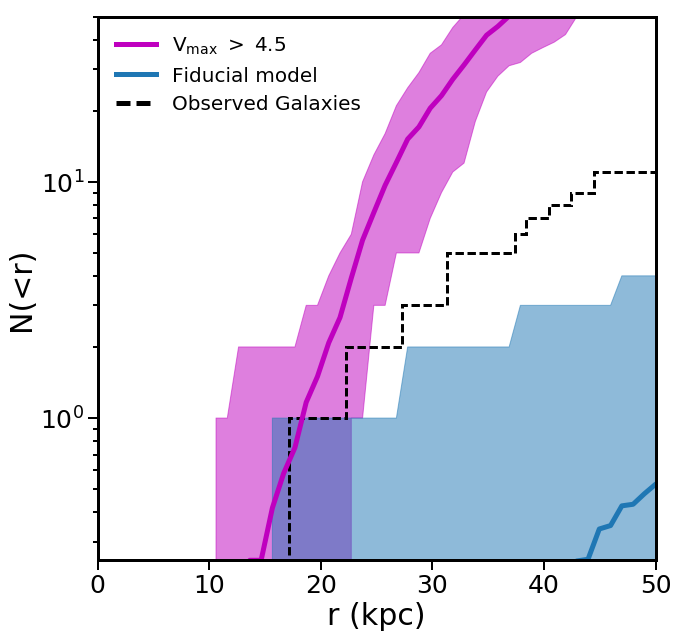

In [87]:
hist_total_all = np.array(hist_total_all)
hist_tot_mean = np.mean(hist_total_all,axis=0)
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_mean = np.mean(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

hist_total_fid = np.array(hist_total_fid)
hist_fid_med = np.median(hist_total_fid,axis=0)
hist_fid_mean = np.mean(hist_total_fid,axis=0)
hist_fid_low = np.percentile(hist_total_fid,84.1,axis=0)
hist_fid_high = np.percentile(hist_total_fid,15.9,axis=0)
hist_fid_min = np.min(hist_total_fid,axis=0)
hist_fid_max = np.max(hist_total_fid,axis=0)

hist_total_wide = np.array(hist_total_wide)
hist_wide_med = np.median(hist_total_wide,axis=0)
hist_wide_mean = np.mean(hist_total_wide,axis=0)
hist_wide_low = np.percentile(hist_total_wide,84.1,axis=0)
hist_wide_high = np.percentile(hist_total_wide,15.9,axis=0)
hist_wide_min = np.min(hist_total_wide,axis=0)
hist_wide_max = np.max(hist_total_wide,axis=0)

hist_total_low = np.array(hist_total_low)
hist_low_med = np.median(hist_total_low,axis=0)
hist_low_mean =  np.mean(hist_total_low,axis=0)
hist_low_low = np.percentile(hist_total_low,84.1,axis=0)
hist_low_high = np.percentile(hist_total_low,15.9,axis=0)
hist_low_min = np.min(hist_total_low,axis=0)
hist_low_max = np.max(hist_total_low,axis=0)

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

print hist_low_min

large_gal_dist = gal_dist[large_gal_mask]

#print hist_fid_mean, hist_fid_med

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_mean,color='m',linewidth=5,label='$V_{max}$ $>$ 4.5')
plt.fill_between(r_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

plt.plot(r_bins_plot,hist_fid_mean,color='C0',linewidth=5,label='Fiducial model')
plt.fill_between(r_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)

#plt.plot(r_bins_plot,hist_wide_mean,color='C1',linewidth=5,label='Wide model')
#plt.fill_between(r_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)

#plt.plot(r_bins_plot,hist_low_mean,color='C2',linewidth=5,label='Low model')
#plt.fill_between(r_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)

data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--')
plt.plot([],[],color='k',linewidth=5,label='Observed Galaxies',linestyle='--')

plt.yscale('log')

plt.xlim([0.0,50.0])
plt.ylim([0.25,50.0])
plt.yscale('log')
plt.xlabel('r (kpc)',fontsize=30)
plt.ylabel('N(<r)',fontsize=30)
plt.legend(fontsize=20,frameon=False)
plt.savefig('./plots_for_paper/radial_fiducial.png',bbox_inches='tight')
plt.show()

In [131]:
h = 0.6751

numbins = 1000

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]
hist_total_fid, hist_total_wide, hist_total_low = [],[],[]

hist_total_all_vmax, hist_total_des_vmax, hist_total_both_vmax = [],[],[]
hist_total_fid_vmax, hist_total_wide_vmax, hist_total_low_vmax = [],[],[]

v_bins = np.linspace(0.0,40.0,30)
v_bins_plot = np.array([(v_bins[ii]+v_bins[ii+1])/2.0 for ii in range(len(v_bins)-1)])

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]

    print Data_Mass_cut[host_index]/1.0e12

    print Data_Vpeak_cut
    
    Andr = 0
    MW = host_index

    for ii in range(100):
        in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, MW)

        in_both = in_des | in_sdss_b | in_sdss_s
        
        distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

        #print distances
        
        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

        in_all = in_des | in_sdss_b | in_sdss_s

        hist_tot, bins_tot = np.histogram(Data_Vpeak_cut[(distances>0.0)&(distances<50.0)],v_bins)
        hist_total_all.append(hist_tot)
        
        hist_both, bins_both = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&(distances<50.0)],v_bins)
        hist_total_both.append(hist_both)
        
        hist_fid, bins_fid = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip&(distances<50.0)],v_bins)
        hist_total_fid.append(hist_fid)
        
        hist_wide, bins_wide = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_wide&(distances<50.0)],v_bins)
        hist_total_wide.append(hist_wide)
        
        hist_low, bins_low = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_low&(distances<50.0)],v_bins)
        hist_total_low.append(hist_low)
        
        #Vmax
        hist_tot, bins_tot = np.histogram(Data_M_cut[(distances>0.0)&(distances<50.0)],v_bins)  
        hist_total_all_vmax.append(hist_tot)
        
        hist_both, bins_both = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&(distances<50.0)],v_bins)
        hist_total_both_vmax.append(hist_both)
        
        hist_fid, bins_fid = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip&(distances<50.0)],v_bins)
        hist_total_fid_vmax.append(hist_fid)
        
        hist_wide, bins_wide = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_wide&(distances<50.0)],v_bins)
        hist_total_wide_vmax.append(hist_wide)
        
        hist_low, bins_low = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_low&(distances<50.0)],v_bins)
        hist_total_low_vmax.append(hist_low)

reduced_data_1107_from_mt.txt
1.7859999999999998e-10
[178.6  127.17  97.38 ...   3.31   3.92   4.78]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in less_equal


reduced_data_1245_from_mt.txt
1.7293000000000002e-10
[172.93  65.17  61.41 ...   5.61   3.01   5.09]
reduced_data_1386_from_mt.txt
1.6350999999999999e-10
[163.51  86.21  90.58 ...   4.23   3.83   4.51]
reduced_data_493_from_mt.txt
2.0222999999999998e-10
[202.23 112.49 104.24 ...   4.36   3.99   4.28]
reduced_data_539_from_mt.txt
2.0571e-10
[205.71  91.51  70.98 ...   4.51   3.27   4.38]
reduced_data_609_from_mt.txt
1.9558e-10
[195.58  87.08  94.63 ...   3.19   3.05   4.17]
reduced_data_694_from_mt.txt
1.8947e-10
[189.47 110.3   94.35 ...   3.74   3.16   3.22]
reduced_data_795_from_mt.txt
1.8771000000000002e-10
[187.71 104.41 104.37 ...   4.51   3.16   6.01]
reduced_data_833_from_mt.txt
1.6550999999999998e-10
[165.51 113.06  95.41 ...   3.87   4.48   5.28]
reduced_data_848_from_mt.txt
2.0233000000000001e-10
[201.95 107.27  81.27 ...   4.29   4.52   4.76]
reduced_data_879_from_mt.txt
1.8047999999999998e-10
[180.48 117.81  72.04 ...   5.24   4.31   3.65]
reduced_data_988_from_mt.txt
1.713

[16.62768775266122, 18.186533479473212, 7.967433714816835, 6.408587988004846, 3.81051177665153, 11.604740410711477, 6.928203230275509, 5.715767664977294, 2.0784609690826525]


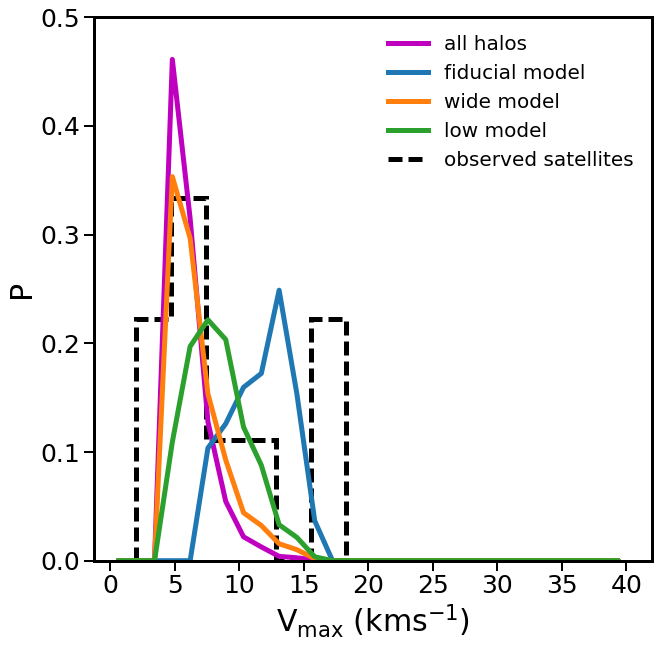

In [135]:
#['Sagittarius I ' 'Bootes II' 'Coma' 'Segue I' 'Segue II' 'Ursa Major II'
# 'Willman I' 'Cetus II' 'Reticulum II' 'Tucana III' 'Tucana IV']
#No velocty for Cetus II and Tuc IV, and Segue 2 and Tuc 3 are upper limits
V_disp_in_50 = [9.6,10.5,4.6,3.7,2.2,6.7,4.0,3.3,1.2]

#V_disp_in_50 = [11.4,10.5,4.6,3.9,3.4,6.7,4.3,3.22,2.9,14.0]
V_c_in_50 = [np.sqrt(3.0)*xx for xx in V_disp_in_50]
print V_c_in_50
v_bins_data = np.linspace(2.0,40.0,15)


hist_total_all = np.array(hist_total_all)
hist_tot_mean = np.mean(hist_total_all,axis=0)
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_mean = np.mean(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

hist_total_fid = np.array(hist_total_fid)
hist_fid_med = np.median(hist_total_fid,axis=0)
hist_fid_mean = np.mean(hist_total_fid,axis=0)
hist_fid_low = np.percentile(hist_total_fid,99,axis=0)
hist_fid_high = np.percentile(hist_total_fid,1,axis=0)
hist_fid_min = np.min(hist_total_fid,axis=0)
hist_fid_max = np.max(hist_total_fid,axis=0)

hist_total_wide = np.array(hist_total_wide)
hist_wide_med = np.median(hist_total_wide,axis=0)
hist_wide_mean = np.mean(hist_total_wide,axis=0)
hist_wide_low = np.percentile(hist_total_wide,99,axis=0)
hist_wide_high = np.percentile(hist_total_wide,1,axis=0)
hist_wide_min = np.min(hist_total_wide,axis=0)
hist_wide_max = np.max(hist_total_wide,axis=0)

hist_total_low = np.array(hist_total_low)
hist_low_med = np.median(hist_total_low,axis=0)
hist_low_mean =  np.mean(hist_total_low,axis=0)
hist_low_low = np.percentile(hist_total_low,99,axis=0)
hist_low_high = np.percentile(hist_total_low,1,axis=0)
hist_low_min = np.min(hist_total_low,axis=0)
hist_low_max = np.max(hist_total_low,axis=0)

#vmax
hist_total_all_vmax = np.array(hist_total_all_vmax)
hist_tot_mean_vmax = np.mean(hist_total_all_vmax,axis=0)
hist_tot_med_vmax = np.median(hist_total_all_vmax,axis=0)
hist_tot_min_vmax = np.min(hist_total_all_vmax,axis=0)
hist_tot_max_vmax = np.max(hist_total_all_vmax,axis=0)

hist_total_both_vmax = np.array(hist_total_both_vmax)
hist_both_med_vmax = np.median(hist_total_both_vmax,axis=0)
hist_both_mean_vmax = np.mean(hist_total_both_vmax,axis=0)
hist_both_min_vmax = np.min(hist_total_both_vmax,axis=0)
hist_both_max_vmax = np.max(hist_total_both_vmax,axis=0)

hist_total_fid_vmax = np.array(hist_total_fid_vmax)
hist_fid_med_vmax = np.median(hist_total_fid_vmax,axis=0)
hist_fid_mean_vmax = np.mean(hist_total_fid_vmax,axis=0)
hist_fid_low_vmax = np.percentile(hist_total_fid_vmax,99,axis=0)
hist_fid_high_vmax = np.percentile(hist_total_fid_vmax,1,axis=0)
hist_fid_min_vmax = np.min(hist_total_fid_vmax,axis=0)
hist_fid_max_vmax = np.max(hist_total_fid_vmax,axis=0)

hist_total_wide_vmax = np.array(hist_total_wide_vmax)
hist_wide_med_vmax = np.median(hist_total_wide_vmax,axis=0)
hist_wide_mean_vmax = np.mean(hist_total_wide_vmax,axis=0)
hist_wide_low_vmax = np.percentile(hist_total_wide_vmax,99,axis=0)
hist_wide_high_vmax = np.percentile(hist_total_wide_vmax,1,axis=0)
hist_wide_min_vmax = np.min(hist_total_wide_vmax,axis=0)
hist_wide_max_vmax = np.max(hist_total_wide_vmax,axis=0)

hist_total_low_vmax = np.array(hist_total_low_vmax)
hist_low_med_vmax = np.median(hist_total_low_vmax,axis=0)
hist_low_mean_vmax =  np.mean(hist_total_low_vmax,axis=0)
hist_low_low_vmax = np.percentile(hist_total_low_vmax,99,axis=0)
hist_low_high_vmax = np.percentile(hist_total_low_vmax,1,axis=0)
hist_low_min_vmax = np.min(hist_total_low_vmax,axis=0)
hist_low_max_vmax = np.max(hist_total_low_vmax,axis=0)


fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

#plt.plot(v_bins_plot,hist_tot_mean/np.sum(hist_tot_mean),color='m',linewidth=5,label='all halos')
plt.plot(v_bins_plot,hist_tot_mean_vmax/np.sum(hist_tot_mean_vmax),color='m',linewidth=5,label='all halos')
#plt.plot(v_bins_plot,hist_tot_med,color='m',linewidth=3,linestyle='--')
#plt.fill_between(v_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

#plt.plot(v_bins_plot,hist_fid_mean/np.sum(hist_fid_mean),color='C0',linewidth=5,label='fiducial model')
plt.plot(v_bins_plot,hist_fid_mean_vmax/np.sum(hist_fid_mean_vmax),color='C0',linewidth=5,label='fiducial model')
#plt.fill_between(v_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_fid_low,hist_fid_high,color='C0',alpha=0.5)

#plt.plot(v_bins_plot,hist_wide_mean/np.sum(hist_wide_mean),color='C1',linewidth=5,label='wide model')
plt.plot(v_bins_plot,hist_wide_mean_vmax/np.sum(hist_wide_mean_vmax),color='C1',linewidth=5,label='wide model')
#plt.fill_between(v_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_wide_low,hist_wide_high,color='C1',alpha=0.5)

#plt.plot(v_bins_plot,hist_low_mean/np.sum(hist_low_mean),color='C2',linewidth=5,label='low model')
plt.plot(v_bins_plot,hist_low_mean_vmax/np.sum(hist_low_mean_vmax),color='C2',linewidth=5,label='low model')
#plt.fill_between(v_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_low_low,hist_low_high,color='C2',alpha=0.5)

V_c_weights = np.ones_like(V_c_in_50)*1.0/float(len(V_c_in_50))

plt.hist(V_c_in_50,bins=v_bins_data,weights=V_c_weights,color='k',linestyle='--',histtype='step',linewidth=5,zorder=0)
plt.plot([],[],color='k',linestyle='--',linewidth=5,label='observed satellites')

#plt.hist(Vc,bins=v_bins,color='C0',histtype='step',linewidth=5)
#plt.fill_betweenx([0.0,1.0],25.0,30.0,color='GoldenRod',alpha=0.4)

#data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

#plt.yscale('log')

#plt.xlim([0.0,50.0])
plt.ylim([0.0,0.5])
plt.ylabel('P',fontsize=30)
plt.xlabel('$V_{max}$ $(km s^{-1})$',fontsize=30)
#plt.yscale('log')
plt.legend(fontsize=20,frameon=False)
plt.savefig('./plots_for_paper/Vmax_models_norm.png',bbox_inches='tight')
plt.show()

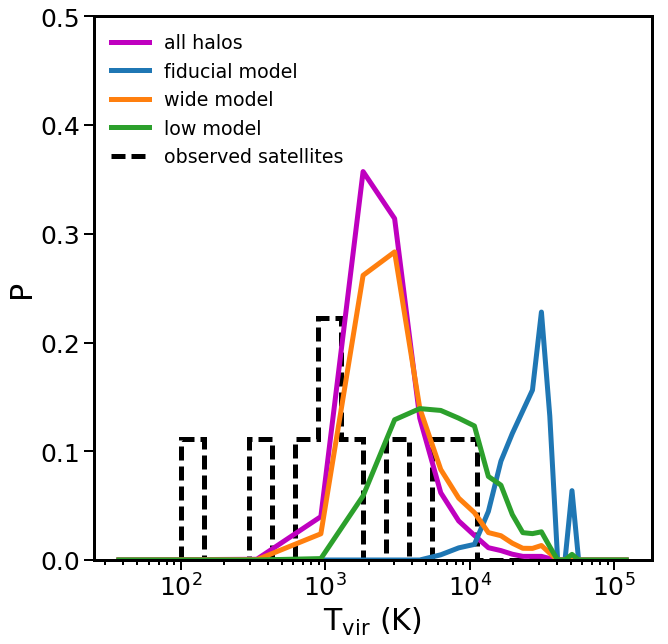

In [137]:
#['Sagittarius I ' 'Bootes II' 'Coma' 'Segue I' 'Segue II' 'Ursa Major II'
# 'Willman I' 'Cetus II' 'Reticulum II' 'Tucana III' 'Tucana IV']
#No velocty for Cetus II and Tuc IV, and Segue 2 and Tuc 3 are upper limits
V_disp_in_50 = [9.6,10.5,4.6,3.7,2.2,6.7,4.0,3.3,1.2]

T_in_50 = [1.0e4*(xx/11.3)**2.0 for xx in V_disp_in_50]

#V_disp_in_50 = [11.4,10.5,4.6,3.9,3.4,6.7,4.3,3.22,2.9,14.0]
V_c_in_50 = [np.sqrt(3.0)*xx for xx in V_disp_in_50]

T_bins_plot = np.array([1.0e4*(xx/11.3)**2.0 for xx in v_bins_plot])

T_bins_data = np.logspace(2.0,5.0,20)

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(T_bins_plot,hist_tot_mean/np.sum(hist_tot_mean),color='m',linewidth=5,label='all halos')
#plt.plot(T_bins_plot,hist_tot_mean_vmax/np.sum(hist_tot_mean_vmax),color='m',linewidth=5,label='all halos')
#plt.plot(v_bins_plot,hist_tot_med,color='m',linewidth=3,linestyle='--')
#plt.fill_between(v_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

plt.plot(T_bins_plot,hist_fid_mean/np.sum(hist_fid_mean),color='C0',linewidth=5,label='fiducial model')
#plt.plot(T_bins_plot,hist_fid_mean_vmax/np.sum(hist_fid_mean_vmax),color='C0',linewidth=5,label='fiducial model')
#plt.fill_between(v_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_fid_low,hist_fid_high,color='C0',alpha=0.5)

plt.plot(T_bins_plot,hist_wide_mean/np.sum(hist_wide_mean),color='C1',linewidth=5,label='wide model')
#plt.plot(T_bins_plot,hist_wide_mean_vmax/np.sum(hist_wide_mean_vmax),color='C1',linewidth=5,label='wide model')
#plt.fill_between(v_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_wide_low,hist_wide_high,color='C1',alpha=0.5)

plt.plot(T_bins_plot,hist_low_mean/np.sum(hist_low_mean),color='C2',linewidth=5,label='low model')
#plt.plot(T_bins_plot,hist_low_mean_vmax/np.sum(hist_low_mean_vmax),color='C2',linewidth=5,label='low model')
#plt.fill_between(v_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_low_low,hist_low_high,color='C2',alpha=0.5)

V_c_weights = np.ones_like(V_c_in_50)*1.0/float(len(V_c_in_50))

plt.hist(T_in_50,bins=T_bins_data,weights=V_c_weights,color='k',linestyle='--',histtype='step',linewidth=5,zorder=0)
plt.plot([],[],color='k',linestyle='--',linewidth=5,label='observed satellites')

#plt.hist(Vc,bins=v_bins,color='C0',histtype='step',linewidth=5)
#plt.fill_betweenx([0.0,1.0],25.0,30.0,color='GoldenRod',alpha=0.4)

#data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

#plt.yscale('log')

#plt.xlim([0.0,50.0])
plt.ylim([0.0,0.5])
plt.ylabel('P',fontsize=30)
plt.xlabel('$T_{vir}$ $(K)$',fontsize=30)
plt.xscale('log')
plt.legend(fontsize=19,loc=2,frameon=False)
plt.savefig('./plots_for_paper/T_from_V_peak.png',bbox_inches='tight')
plt.show()